<a href="https://colab.research.google.com/github/jasimrashid/DS-Unit-1-Sprint-2-Statistics/blob/master/module2/LS_DS_122_Sampling_Confidence_Intervals_and_Hypothesis_Testing_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment - Build a confidence interval

A confidence interval refers to a neighborhood around some point estimate, the size of which is determined by the desired p-value. For instance, we might say that 52% of Americans prefer tacos to burritos, with a 95% confidence interval of +/- 5%.

52% (0.52) is the point estimate, and +/- 5% (the interval $[0.47, 0.57]$) is the confidence interval. "95% confidence" means a p-value $\leq 1 - 0.95 = 0.05$.

In this case, the confidence interval includes $0.5$ - which is the natural null hypothesis (that half of Americans prefer tacos and half burritos, thus there is no clear favorite). So in this case, we could use the confidence interval to report that we've failed to reject the null hypothesis.

But providing the full analysis with a confidence interval, including a graphical representation of it, can be a helpful and powerful way to tell your story. Done well, it is also more intuitive to a layperson than simply saying "fail to reject the null hypothesis" - it shows that in fact the data does *not* give a single clear result (the point estimate) but a whole range of possibilities.

How is a confidence interval built, and how should it be interpreted? It does *not* mean that 95% of the data lies in that interval - instead, the frequentist interpretation is "if we were to repeat this experiment 100 times, we would expect the average result to lie in this interval ~95 times."

For a 95% confidence interval and a normal(-ish) distribution, you can simply remember that +/-2 standard deviations contains 95% of the probability mass, and so the 95% confidence interval based on a given sample is centered at the mean (point estimate) and has a range of +/- 2 (or technically 1.96) standard deviations.

Different distributions/assumptions (90% confidence, 99% confidence) will require different math, but the overall process and interpretation (with a frequentist approach) will be the same.

Your assignment - using the data from the prior module ([congressional voting records](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records)):


### Confidence Intervals:
1. Generate and numerically represent a confidence interval
2. Graphically (with a plot) represent the confidence interval
3. Interpret the confidence interval - what does it tell you about the data and its distribution?

### Chi-squared tests:
4. Take a dataset that we have used in the past in class that has **categorical** variables. Pick two of those categorical variables and run a chi-squared tests on that data
  - By hand using Numpy
  - In a single line using Scipy


In [63]:
import pandas as pd
import numpy as np
from scipy.stats import t, ttest_1samp
import matplotlib.pyplot as plt
import seaborn as sns


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [64]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data

--2020-04-15 11:12:56--  https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18171 (18K) [application/x-httpd-php]
Saving to: ‘house-votes-84.data’

house-votes-84.data 100%[===================>]  17.75K  --.-KB/s    in 0.06s   

2020-04-15 11:12:56 (286 KB/s) - ‘house-votes-84.data’ saved [18171/18171]



In [65]:
column_headers = ['party','handicapped-infants','water-project',
                  'budget','physician-fee-freeze', 'el-salvador-aid',
                  'religious-groups','anti-satellite-ban',
                  'aid-to-contras','mx-missile','immigration',
                  'synfuels', 'education', 'right-to-sue','crime','duty-free',
                  'south-africa']

df=pd.read_csv('house-votes-84.data', names=column_headers)

print(df.shape)
df.head()

(435, 17)


,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
0,republican,n,y,n,y,y,y,n,n,n,y,?,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,?
2,democrat,?,y,y,?,y,y,n,n,n,n,y,n,y,y,n,n
3,democrat,n,y,y,n,?,y,n,n,n,n,y,n,y,n,n,y
4,democrat,y,y,y,n,y,y,n,n,n,n,y,?,y,y,y,y


In [66]:
df=df.replace({'y':1,'n':0,'?':np.NaN})
df.head()

,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
0,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,0.0,1.0
1,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,NaN
2,democrat,NaN,1.0,1.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,democrat,0.0,1.0,1.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,democrat,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,1.0


In [0]:
dem = df[df['party']=='democrat']
rep = df[df['party']=='republican']

1. Generate and numerically represent a confidence interval
2. Graphically (with a plot) represent the confidence interval
3. Interpret the confidence interval - what does it tell you about the data and its distribution?

In [0]:
x = dem['physician-fee-freeze']

def conf_interval(x):
  n=len(x)

  dof = n-1
  mean = np.mean(x)
  sample_std = np.std(x, ddof=1)
  std_err = sample_std/n**.5
  CI = t.interval(.95, dof, loc=mean, scale=std_err)
  return CI, mean, std_err

In [0]:
# n #267
# mean #0.05405405405405406
# std_err #0.013865377375546896
# print("95% CI: ", CI)

In [69]:
column_name = 'education'
x = dem[column_name].dropna()
CI, mean_dem, std_err = conf_interval(x)
lower = CI[0]
upper = CI[1]
moe_dem = mean_dem - lower
print("CI of democrats' position on", column_name, ": ", CI)

x = rep[column_name].dropna()
CI, mean_rep, std_err = conf_interval(x)
lower = CI[0]
upper = CI[1]
moe_rep = mean_rep - lower
print("CI of republicans' position on", column_name, ": ", CI)

# print(plt.errorbar(["dem"], mean_dem, yerr=moe_dem, fmt='o')
# plt.errorbar(["rep"], mean_rep, yerr=moe_rep, fmt='o')


CI of democrats' position on education :  (0.1005949402232755, 0.18856168628274858)
CI of republicans' position on education :  (0.8176017935029392, 0.9243336903680286)


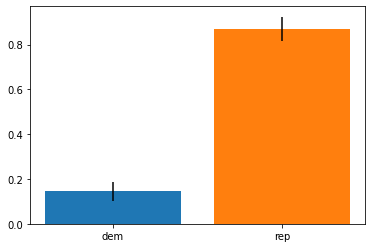

In [70]:
plt.bar(["dem"], mean_dem, yerr=moe_dem)
plt.bar(["rep"], mean_rep, yerr=moe_rep)
plt.show()

<ErrorbarContainer object of 3 artists>

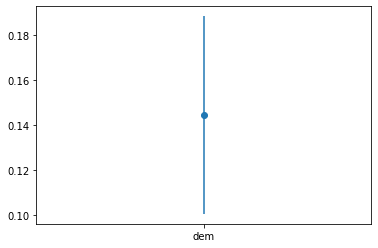

In [71]:

plt.errorbar(["dem"], mean_dem, yerr=moe_dem, fmt='o')


**Interpreting the confidence interval**

There is a 95% chance that 0.1005949402232755, 0.18856168628274858) captures the mean position of democrats position on physician fee freezes.

There is a 95% chance that (0.8176017935029392, 0.9243336903680286) captures the mean position of republican position on physician fee freezes.  



Take a dataset that we have used in the past in class that has categorical variables. Pick two of those categorical variables and run a chi-squared tests on that data:


**By hand using Numpy**

In [13]:
import numpy as np
import pandas as pd
column_headers = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 
                 'marital-status', 'occupation', 'relationship', 'race', 'sex', 
                 'capital-gain',  'capital-loss', 'hours-per-week', 
                 'native-country', 'income']

adult_dataset = 'https://raw.githubusercontent.com/ryanleeallred/datasets/master/adult_original.data'

df = pd.read_csv(adult_dataset, names=column_headers)
print(df.shape)
df.head(5)

(32561, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [16]:
df['education-num'].value_counts().sort_index()

1        51
2       168
3       333
4       646
5       514
6       933
7      1175
8       433
9     10501
10     7291
11     1382
12     1067
13     5355
14     1723
15      576
16      413
Name: education-num, dtype: int64

In [17]:
df['workclass'].value_counts().sort_index()

 ?                    1836
 Federal-gov           960
 Local-gov            2093
 Never-worked            7
 Private             22696
 Self-emp-inc         1116
 Self-emp-not-inc     2541
 State-gov            1298
 Without-pay            14
Name: workclass, dtype: int64

In [0]:
import numpy as np
def clean_emp_title(title):
  if isinstance(title, str):
    if title.strip().title() == '?':
      return np.NaN
    else:
      return title.strip().title()
  else: 
    return "Unknown"

df['workclass'] = df['workclass'].apply(clean_emp_title)

In [19]:
df['workclass'].value_counts().sort_index()

Federal-Gov           960
Local-Gov            2093
Never-Worked            7
Private             22696
Self-Emp-Inc         1116
Self-Emp-Not-Inc     2541
State-Gov            1298
Without-Pay            14
Name: workclass, dtype: int64

In [0]:
observed = pd.crosstab(df['education-num'],df['workclass'].dropna())

In [53]:
observed_margins = pd.crosstab(df['education-num'],df['workclass'].dropna(), margins=True)
observed_margins

workclass,Federal-Gov,Local-Gov,Never-Worked,Private,Self-Emp-Inc,Self-Emp-Not-Inc,State-Gov,Without-Pay,All
education-num,,,,,,,,,
1,0,4,0,41,0,0,1,0,46
2,0,4,0,136,2,13,1,0,156
3,1,9,0,266,4,19,4,0,303
4,2,28,1,424,14,94,10,1,574
5,3,23,0,387,10,34,6,0,463
6,6,31,2,695,19,67,13,0,833
7,9,36,1,923,14,60,14,0,1057
8,5,19,0,333,7,19,10,0,393
9,263,503,1,7780,279,866,268,9,9969


In [0]:
# observed = pd.crosstab(df['sex'], df['education-num'])

# observed

In [0]:
# observed_margins = pd.crosstab(df['sex'], df['education-num'], margins=True)
# observed_margins

In [58]:
row_sums = observed_margins.iloc[0:16, 8:].values
row_sums = row_sums.T[0]

row_sums

array([  46,  156,  303,  574,  463,  833, 1057,  393, 9969, 6777, 1321,
       1020, 5182, 1675,  558,  398])

In [57]:
col_sums = observed_margins.iloc[16:, 0:8].values
col_sums = col_sums[0]

col_sums

array([  960,  2093,     7, 22696,  1116,  2541,  1298,    14])

In [59]:
total_total = df.dropna().shape[0]

total_total

30725

In [60]:
expected = []
for i in range(len(row_sums)):
  expected_row = []
  for column in col_sums:
    expected_val = column*row_sums[i]/total_total
    expected_row.append(expected_val)
  expected.append(expected_row)

expected = np.array(expected)
print(expected.shape)  
print(expected)

(16, 8)
[[1.43726607e+00 3.13353946e+00 1.04800651e-02 3.39793653e+01
  1.67082181e+00 3.80426363e+00 1.94330350e+00 2.09601302e-02]
 [4.87420667e+00 1.06267860e+01 3.55410903e-02 1.15234369e+02
  5.66626526e+00 1.29014158e+01 6.59033360e+00 7.10821806e-02]
 [9.46720911e+00 2.06404882e+01 6.90317331e-02 2.23820602e+02
  1.10056306e+01 2.50585191e+01 1.28004557e+01 1.38063466e-01]
 [1.79345810e+01 3.91011229e+01 1.30772986e-01 4.24003385e+02
  2.08489504e+01 4.74705940e+01 2.42490480e+01 2.61545972e-01]
 [1.44663954e+01 3.15397559e+01 1.05484133e-01 3.42009699e+02
  1.68171847e+01 3.82907404e+01 1.95597722e+01 2.10968267e-01]
 [2.60270138e+01 5.67443124e+01 1.89780309e-01 6.15321985e+02
  3.02564036e+01 6.88902522e+01 3.51906916e+01 3.79560618e-01]
 [3.30258747e+01 7.20032872e+01 2.40813670e-01 7.80786721e+02
  3.83925793e+01 8.74153621e+01 4.46537347e+01 4.81627339e-01]
 [1.22792514e+01 2.67713263e+01 8.95362083e-02 2.90301969e+02
  1.42746298e+01 3.25016436e+01 1.66025712e+01 1.790724

In [61]:
chi2 = ((observed-expected)**2 / expected).sum().sum()

chi2

2247.538854811734

**In a single line using Scipy**

In [27]:
from scipy import stats
chi2, p_value, dof, expected = stats.chi2_contingency(observed)

print("chi2 statistic", chi2)
print("p value", p_value)
print("degrees of freedom",dof)
print("expected frequencies table", expected)

chi2 statistic 2247.538854811734
p value 0.0
degrees of freedom 105
expected frequencies table [[1.43726607e+00 3.13353946e+00 1.04800651e-02 3.39793653e+01
  1.67082181e+00 3.80426363e+00 1.94330350e+00 2.09601302e-02]
 [4.87420667e+00 1.06267860e+01 3.55410903e-02 1.15234369e+02
  5.66626526e+00 1.29014158e+01 6.59033360e+00 7.10821806e-02]
 [9.46720911e+00 2.06404882e+01 6.90317331e-02 2.23820602e+02
  1.10056306e+01 2.50585191e+01 1.28004557e+01 1.38063466e-01]
 [1.79345810e+01 3.91011229e+01 1.30772986e-01 4.24003385e+02
  2.08489504e+01 4.74705940e+01 2.42490480e+01 2.61545972e-01]
 [1.44663954e+01 3.15397559e+01 1.05484133e-01 3.42009699e+02
  1.68171847e+01 3.82907404e+01 1.95597722e+01 2.10968267e-01]
 [2.60270138e+01 5.67443124e+01 1.89780309e-01 6.15321985e+02
  3.02564036e+01 6.88902522e+01 3.51906916e+01 3.79560618e-01]
 [3.30258747e+01 7.20032872e+01 2.40813670e-01 7.80786721e+02
  3.83925793e+01 8.74153621e+01 4.46537347e+01 4.81627339e-01]
 [1.22792514e+01 2.67713263e+0

## Stretch goals:

1. Write a summary of your findings, mixing prose and math/code/results. *Note* - yes, this is by definition a political topic. It is challenging but important to keep your writing voice *neutral* and stick to the facts of the data. Data science often involves considering controversial issues, so it's important to be sensitive about them (especially if you want to publish).
2. Apply the techniques you learned today to your project data or other data of your choice, and write/discuss your findings here.
3. Refactor your code so it is elegant, readable, and can be easily run for all issues.

## Resources

- [Interactive visualize the Chi-Squared test](https://homepage.divms.uiowa.edu/~mbognar/applets/chisq.html)
- [Calculation of Chi-Squared test statistic](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test)
- [Visualization of a confidence interval generated by R code](https://commons.wikimedia.org/wiki/File:Confidence-interval.svg)
- [Expected value of a squared standard normal](https://math.stackexchange.com/questions/264061/expected-value-calculation-for-squared-normal-distribution) (it's 1 - which is why the expected value of a Chi-Squared with $n$ degrees of freedom is $n$, as it's the sum of $n$ squared standard normals)